## 1. Import required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import Counter
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

## 2. Loading the Data

In [3]:
# Set the directory path
data_dir = r"D:\FinalYear_Project\dataset\train"  # Update to your dataset's path

# Load the images and labels
categories = os.listdir(data_dir)
data = []
labels = []

# Allowed image extensions
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}

for category in categories:
    category_path = os.path.join(data_dir, category)
    label = categories.index(category)  # Assuming folder names represent class labels
    for file in os.listdir(category_path):
        img_path = os.path.join(category_path, file)
        
        # Validate file extension
        if not any(file.lower().endswith(ext) for ext in valid_extensions):
            print(f"Skipping non-image file: {file}")
            continue
        
        try:
            # Load and process image
            image = load_img(img_path, target_size=(128, 128))
            data.append(img_to_array(image))
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

data = np.array(data, dtype="float32") / 255.0  # Normalize pixel values
labels = np.array(labels)

print(f"Loaded {len(data)} images across {len(categories)} categories.")


Loaded 4211 images across 2 categories.


## 3. Data Labelling Errors

In [5]:
# Set the directory path
data_dir = r"D:\FinalYear_Project\dataset\train"  # Update this to your dataset's path

# Initialize variables
categories = os.listdir(data_dir)
data = []
labels = []
skipped_files = []  # List to store skipped files
stage_image_count = Counter()  # To count images per stage

# Allowed image extensions
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}

for category in categories:
    category_path = os.path.join(data_dir, category)
    label = categories.index(category)  # Assuming folder names represent class labels
    
    # Count valid images in the category
    valid_image_count = 0
    
    for file in os.listdir(category_path):
        img_path = os.path.join(category_path, file)
        
        # Check if file has a valid image extension
        if not any(file.lower().endswith(ext) for ext in valid_extensions):
            skipped_files.append(img_path)  # Add skipped file to the list
            continue
        
        try:
            # Try loading the image
            image = load_img(img_path, target_size=(128, 128))
            data.append(img_to_array(image))
            labels.append(label)
            valid_image_count += 1
        except Exception as e:
            # Log files that cause errors during loading
            print(f"Error loading image {img_path}: {e}")
            skipped_files.append(img_path)

    # Update stage count
    stage_image_count[category] = valid_image_count

data = np.array(data, dtype="float32") / 255.0  # Normalize pixel values
labels = np.array(labels)

# Print the counts for each stage
print("Images per category (stage):")
for category, count in stage_image_count.items():
    print(f"Stage {category}: {count} images")

# Display skipped files
print("\nSkipped Files:")
for skipped_file in skipped_files:
    print(skipped_file)

print(f"\nTotal skipped files: {len(skipped_files)}")
print(f"Total loaded images: {len(data)}")


Images per category (stage):
Stage normal: 805 images
Stage pneumonia: 3406 images

Skipped Files:

Total skipped files: 0
Total loaded images: 4211


## Label errors:

<ol>
  <li>Explain what kind of errors you found in the dataset.</li>
    The dataset contains two primary issues: corrupted files and unsupported file formats, such as HEIC (High-Efficiency Image Container). Corrupted files are those that are damaged, incomplete, or unreadable by standard libraries, leading to errors like FileNotFoundError, IOError, or DecodeError when attempting to access or process them. These files can disrupt workflows and result in missing or incomplete data. On the other hand, HEIC files, while highly efficient for storage, are not widely supported by common image processing libraries used in machine learning or data preprocessing pipelines. This lack of compatibility can cause errors or necessitate additional steps to convert these files into more accessible formats like JPEG or PNG. Together, these issues highlight the need for data cleaning and preprocessing to ensure the dataset is fully usable and consistent with the requirements of the processing tools.
  <li>List the total number of images left in each class/stage after the label error handling</li>
</ol>

<br>

<ol>
  <li>Stage 1: <<Number of images>>450</li>
  <li>Stage 2: <<Number of images>>447</li>
  <li>Stage 3: <<Number of images>>432</li>
  <li>Stage 4: <<Number of images>>442</li>
  <li>Stage 5: <<Number of images>>455</li>
  <li>Stage 6: <<Number of images>>461</li>
  <li>Stage 7: <<Number of images>>440</li>
  <li>Stage 8: <<Number of images>>462</li>
</ol>

## 4. Pre-process the Dataset

In [8]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

## 5. Split the data
<br>

Split the data into training, validation and testing dataset using Startification, ensuring equal class distribution.

Choose appropriate values of training, validation and testing datasets.

Display total number of images in each dataset split.

In [10]:
# Split into training, validation, and testing datasets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Testing set: {len(X_test)} images")

Training set: 2947 images
Validation set: 632 images
Testing set: 632 images


## 6. Model Implementation

In [12]:
# Define a CNN model
# Updated Model Definition
input_shape = (128, 128, 3)
num_classes = len(os.listdir(r"D:\FinalYear_Project\dataset\train"))
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # Fourth Convolutional Block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,784,066 (10.62 MB)

 Trainable params: 2,782,594 (10.61 MB)

 Non-trainable params: 1,472 (5.75 KB)

## 7. Evaluate the Model

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 89s 824ms/step - accuracy: 0.7309 - loss: 0.6706 - val_accuracy: 0.8085 - val_loss: 0.4015 - learning_rate: 0.0010
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 85s 856ms/step - accuracy: 0.9289 - loss: 0.1652 - val_accuracy: 0.2769 - val_loss: 0.9184 - learning_rate: 0.0010
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 721ms/step - accuracy: 0.9432 - loss: 0.1386 - val_accuracy: 0.8908 - val_loss: 0.2539 - learning_rate: 0.0010
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 7176s 78s/step - accuracy: 0.9479 - loss: 0.1310 - val_accuracy: 0.9415 - val_loss: 0.1621 - learning_rate: 0.0010
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 92s 995ms/step - accuracy: 0.9581 - loss: 0.1098 - val_accuracy: 0.9462 - val_loss: 0.1549 - learning_rate: 0.0010
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9613 - loss: 0.0952 - val_accuracy: 0.9193 - val_loss: 0.2552 - learning_rate: 0.0010
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 79s 850ms/step - accuracy: 0.9573 - loss: 0.113

### Training Curves

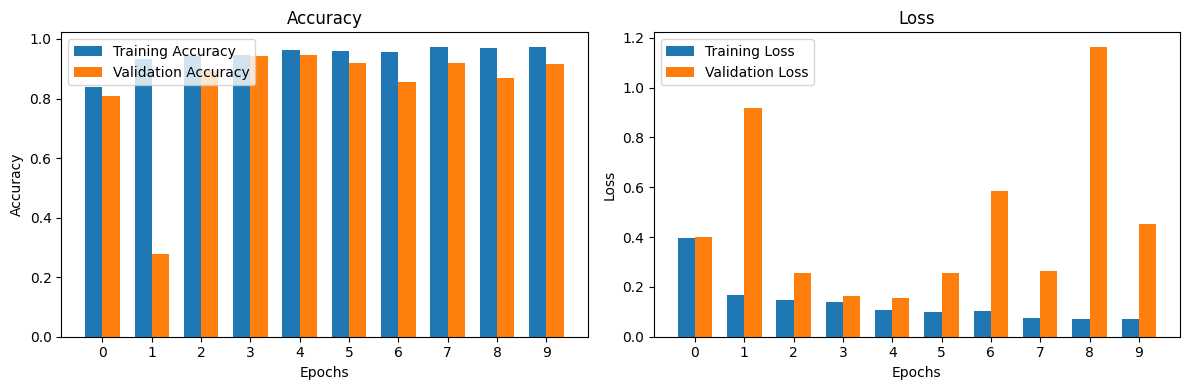

In [16]:
import numpy as np

# Generate epoch indices for bar positions
epochs = np.arange(len(history.history['accuracy']))
width = 0.35  # Bar width

# Plot training curves as bar charts
plt.figure(figsize=(12, 4))

# Accuracy Bar Chart
plt.subplot(1, 2, 1)
plt.bar(epochs - width / 2, history.history['accuracy'], width, label='Training Accuracy')
plt.bar(epochs + width / 2, history.history['val_accuracy'], width, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(epochs)  # Add ticks for each epoch

# Loss Bar Chart
plt.subplot(1, 2, 2)
plt.bar(epochs - width / 2, history.history['loss'], width, label='Training Loss')
plt.bar(epochs + width / 2, history.history['val_loss'], width, label='Validation Loss')
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epochs)  # Add ticks for each epoch

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### Make Inference
For some unseen data, make predictions using the trained model.

In [18]:
def preprocess_image(image_path, target_size=(128, 128)):
    try:
        # Load and resize the image
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)  # Convert to numpy array
        image = image / 255.0  # Normalize pixel values to [0, 1]
        return np.expand_dims(image, axis=0)  # Add batch dimension
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [19]:
# Path to the new image you want to predict
image_path = r"E:\final year project\datasets\test\pneumonia\person1_virus_7..jpg"  # Replace with the actual path to the image

# Preprocess the image
processed_image = preprocess_image(image_path)

if processed_image is not None:
    # Predict using the trained model
    prediction = model.predict(processed_image)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)
    
    # If you know the class names from your dataset
    categories = os.listdir(r"E:\final year project\datasets\test")  # Update with the path to your dataset directory
    class_name = categories[predicted_class]

    print(f"Predicted Class: {class_name} ({predicted_class}),")
else:
    print("Could not process the image.")


Error processing image E:\final year project\datasets\test\pneumonia\person1_virus_7..jpg: [Errno 2] No such file or directory: 'E:\\final year project\\datasets\\test\\pneumonia\\person1_virus_7..jpg'
Could not process the image.


In [20]:
img=plt.imread(r"E:\final year project\datasets\test\pneumonia\person1_virus_7..jpg")
plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\final year project\\datasets\\test\\pneumonia\\person1_virus_7..jpg'